In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Task 1

In [2]:
import os
import tarfile
import glob
from collections import Counter
import numpy as np

# Extract the dataset
tar_file = '/content/drive/MyDrive/AI Projects/Text Classification with LSTM/aclImdb_v1-1.tar.gz'
extract_path = '/content/drive/MyDrive/AI Projects/Text Classification with LSTM/aclImdb'

if not os.path.exists(extract_path):
    with tarfile.open(tar_file, 'r:gz') as tar:
        tar.extractall(path=extract_path)

# Load reviews
def load_reviews(folder):
    texts, labels = [], []
    for label in ['pos', 'neg']:
        files = glob.glob(os.path.join(folder, label, '*.txt'))
        for f in files:
            try:
                with open(f, encoding='utf-8') as file:
                    texts.append(file.read())
                    labels.append(1 if label == 'pos' else 0)
            except OSError as e:
                print(f"Skipping file due to error: {f} ({e})")
    return texts, labels


train_texts, train_labels = load_reviews(os.path.join(extract_path, 'train'))
test_texts, test_labels = load_reviews(os.path.join(extract_path, 'test'))

# Stats: length per review
lengths_train = [len(text.split()) for text in train_texts]
lengths_test = [len(text.split()) for text in test_texts]

def print_stats(name, lengths):
    print(f"{name} Set:")
    print(" - Average length:", np.mean(lengths))
    print(" - Max length:", max(lengths))
    print(" - Min length:", min(lengths), "\n")

print_stats("Train", lengths_train)
print_stats("Test", lengths_test)


Train Set:
 - Average length: 233.7872
 - Max length: 2470
 - Min length: 10 

Test Set:
 - Average length: 228.52668
 - Max length: 2278
 - Min length: 4 



***Task 1 Analysis:***

*The wide variation in review lengths presents a key challenge for sequence modeling using LSTMs, which require fixed-length input sequences.*

*The average review length (~230 words) indicates that most reviews are of moderate length and can be captured well within a 250–300 word window.*

*However, the maximum length (>2200 words) suggests that some reviews are exceptionally long. Allowing such sequences without truncation would lead to very high memory usage and slow training.*

*The minimum length (as low as 4–10 words) indicates the need for padding shorter reviews to maintain uniform sequence length.*

### Task 2

In [4]:

import random
import pandas as pd

train_data = list(zip(train_texts, train_labels))
random.seed(42)
random.shuffle(train_data)

# Separate positive and negative samples
pos_samples = [sample for sample in train_data if sample[1] == 1]
neg_samples = [sample for sample in train_data if sample[1] == 0]

val_pos = pos_samples[:1500]
val_neg = neg_samples[:1500]
val_data = val_pos + val_neg

# training set
train_pos = pos_samples[1500:]
train_neg = neg_samples[1500:]
new_train_data = train_pos + train_neg

new_train_texts, new_train_labels = zip(*new_train_data)
val_texts, val_labels = zip(*val_data)

def report_distribution(name, labels):
    count = Counter(labels)
    print(f"{name} set - Positive: {count[1]}, Negative: {count[0]}")
    print(f"\n{name} Set Distribution:")
    print(f" - Positive: {count[1]}")
    print(f" - Negative: {count[0]}")
    print(f" - Total:    {count[1]+count[0]}")

print("Data Split Summary:")
report_distribution("New Training", new_train_labels)
report_distribution("Validation", val_labels)
report_distribution("Test", test_labels)


Data Split Summary:
New Training set - Positive: 11000, Negative: 11000

New Training Set Distribution:
 - Positive: 11000
 - Negative: 11000
 - Total:    22000
Validation set - Positive: 1500, Negative: 1500

Validation Set Distribution:
 - Positive: 1500
 - Negative: 1500
 - Total:    3000
Test set - Positive: 12500, Negative: 12500

Test Set Distribution:
 - Positive: 12500
 - Negative: 12500
 - Total:    25000


***Task 2 Analysis:***

* *The validation set is perfectly balanced, making it ideal for unbiased model evaluation.*

* *The training set remains balanced, which helps the model learn both classes equally.*

* *The test set distribution is untouched, preserving its role as a true benchmark for final evaluation.*

*This balanced split helps ensure that our model’s performance metrics — such as accuracy, precision, recall, and F1 score are meaningful and not biased toward any class.*

#### Task 3

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(review):

    text = BeautifulSoup(review, "html.parser").get_text()

    text = text.lower()

    text = re.sub(r"[^\w\s]", "", text)

    tokens = nltk.word_tokenize(text)

    filtered = [w for w in tokens if w not in stop_words]

    stemmed = [stemmer.stem(w) for w in filtered]

    return stemmed

# example for preprocessed review
example_raw = new_train_texts[0]
example_clean = preprocess_text(example_raw)

print("Original Review:\n", example_raw[:500], "\n")
print("Preprocessed Review:\n", example_clean[:50], "...")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...


Original Review:
 This is a film that the mainstream market will probably never be able to access as it doesn't exactly give the viewer easy watching. The story about troubled Spike and his friend Heaton is not exactly a Friday night film yet it has its own unique edge and I found that it was entertaining. There are moments of brilliance given that the film was shot on such a low budget, such as when Spike inhales the aerosol. However I did not really understand the relationship between Spike and Heaton and to be 

Preprocessed Review:
 ['film', 'mainstream', 'market', 'probabl', 'never', 'abl', 'access', 'doesnt', 'exactli', 'give', 'viewer', 'easi', 'watch', 'stori', 'troubl', 'spike', 'friend', 'heaton', 'exactli', 'friday', 'night', 'film', 'yet', 'uniqu', 'edg', 'found', 'entertain', 'moment', 'brillianc', 'given', 'film', 'shot', 'low', 'budget', 'spike', 'inhal', 'aerosol', 'howev', 'realli', 'understand', 'relationship', 'spike', 'heaton', 'honest', 'made', 'spend', 'film', 'tr

[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


***Task 3 Analysis:***

I preprocessed each review by converting text to lowercase, removing punctuation, tokenizing into words, filtering out stopwords, and applying stemming to reduce words to their root forms. These preprocessing steps significantly reduce vocabulary size, eliminate irrelevant patterns, and help the LSTM model generalize better.
By converting varied word forms like "entertaining", "entertain", and "entertainment" to a common root ("entertain"), I reduce dimensionality and help the model focus on sentiment-bearing words making them easier to vectorize, more memory-efficient and more semantically meaningful.

### Task 4

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Build vocabulary from training data
def build_vocab(tokenized_texts, min_freq=2):
    word_freq = defaultdict(int)
    for tokens in tokenized_texts:
        for token in tokens:
            word_freq[token] += 1
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# 2. Convert text to sequence of ids
def text_to_sequence(tokens, vocab, max_len=200):
    ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if len(ids) < max_len:
        ids += [vocab['<PAD>']] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

# Preprocess all datasets
train_tokens = [preprocess_text(t) for t in new_train_texts]#preprocessed train data
val_tokens = [preprocess_text(t) for t in val_texts]
test_tokens = [preprocess_text(t) for t in test_texts]

vocab = build_vocab(train_tokens)#passed preprocessed train data to build vocab

train_ids = [text_to_sequence(t, vocab) for t in train_tokens]
val_ids = [text_to_sequence(t, vocab) for t in val_tokens]
test_ids = [text_to_sequence(t, vocab) for t in test_tokens]

# Dataset class
class IMDBDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

# Create loaders
batch_size = 64
train_dl = DataLoader(IMDBDataset(train_ids, new_train_labels), batch_size=batch_size, shuffle=True)
val_dl = DataLoader(IMDBDataset(val_ids, val_labels), batch_size=batch_size)
test_dl = DataLoader(IMDBDataset(test_ids, test_labels), batch_size=batch_size)

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        out = out[:, -1, :]  # last hidden state
        out = self.fc(out)
        return self.sigmoid(out).squeeze()

#Training
def train_model_with_hidden_dim(hidden_dim, epochs=10, lr=0.001):
    print(f"\n Training LSTM with hidden_dim = {hidden_dim}")
    model = LSTMClassifier(vocab_size=len(vocab), embed_dim=128, hidden_dim=hidden_dim, num_layers=1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_loss_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss_history.append(total_loss / len(train_dl))

        # Validation loss and accuracy
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for x_val, y_val in val_dl:
                x_val, y_val = x_val.to(device), y_val.to(device)
                preds = model(x_val)
                loss = criterion(preds, y_val)
                val_loss += loss.item()
                all_preds.extend((preds >= 0.5).cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())
        val_loss_history.append(val_loss / len(val_dl))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_acc_history.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss_history[-1]:.4f}, Val Loss: {val_loss_history[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

    return model, train_loss_history, val_loss_history, val_acc_history


In [12]:
model_64, train_loss_64, val_loss_64, val_acc_64 = train_model_with_hidden_dim(hidden_dim=64)
model_128, train_loss_128, val_loss_128, val_acc_128 = train_model_with_hidden_dim(hidden_dim=128)


 Training LSTM with hidden_dim = 64
Epoch 1/10 - Train Loss: 0.6931, Val Loss: 0.6921, Val Acc: 0.5030
Epoch 2/10 - Train Loss: 0.6832, Val Loss: 0.7364, Val Acc: 0.5203
Epoch 3/10 - Train Loss: 0.6587, Val Loss: 0.6410, Val Acc: 0.6557
Epoch 4/10 - Train Loss: 0.6240, Val Loss: 0.6507, Val Acc: 0.6540
Epoch 5/10 - Train Loss: 0.5762, Val Loss: 0.6236, Val Acc: 0.6970
Epoch 6/10 - Train Loss: 0.5580, Val Loss: 0.6078, Val Acc: 0.7093
Epoch 7/10 - Train Loss: 0.5307, Val Loss: 0.6273, Val Acc: 0.6997
Epoch 8/10 - Train Loss: 0.5296, Val Loss: 0.6272, Val Acc: 0.7060
Epoch 9/10 - Train Loss: 0.5149, Val Loss: 0.6295, Val Acc: 0.7183
Epoch 10/10 - Train Loss: 0.5105, Val Loss: 0.6333, Val Acc: 0.7167

 Training LSTM with hidden_dim = 128
Epoch 1/10 - Train Loss: 0.6933, Val Loss: 0.6936, Val Acc: 0.5113
Epoch 2/10 - Train Loss: 0.6825, Val Loss: 0.6915, Val Acc: 0.5167
Epoch 3/10 - Train Loss: 0.6522, Val Loss: 0.6990, Val Acc: 0.5220
Epoch 4/10 - Train Loss: 0.6781, Val Loss: 0.6952, Va

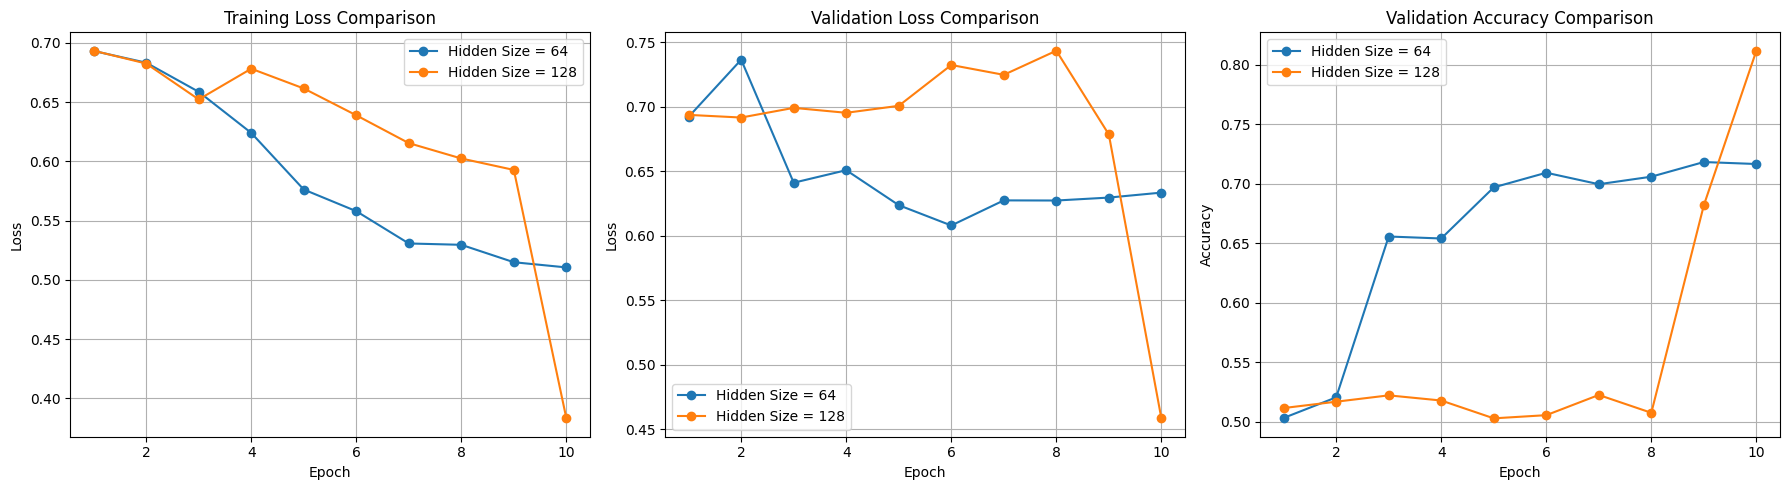

In [18]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))  # For 5 epochs

plt.figure(figsize=(18, 5))

# 1. Training Loss: loss function on training data
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_64, label='Hidden Size = 64', marker='o')
plt.plot(epochs, train_loss_128, label='Hidden Size = 128', marker='o')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Validation Loss: loss computed on the validation dataset(how well the model performs on unseen data)
plt.subplot(1, 3, 2)
plt.plot(epochs, val_loss_64, label='Hidden Size = 64', marker='o')
plt.plot(epochs, val_loss_128, label='Hidden Size = 128', marker='o')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Validation Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, val_acc_64, label='Hidden Size = 64', marker='o')
plt.plot(epochs, val_acc_128, label='Hidden Size = 128', marker='o')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


***Task 4 Analysis:***

*To evaluate the impact of LSTM hidden size on model performance, I trained two models using hidden_dim = 64 and hidden_dim = 128 for 10 epochs. I compared their training loss, validation loss, and validation accuracy across epochs to assess learning dynamics and generalization.*

**Key Observations:**
* Training Loss : Both models showed a steady decrease in training loss, indicating effective learning.
The model with hidden_dim = 128 reached a significantly lower training loss by epoch 10 (0.3832 vs 0.5105), suggesting it learned richer internal representations and fit the training data more effectively.

*  Validation Loss : The hidden_dim = 64 model's validation loss improved until epoch 6 and then plateaued or slightly increased, peaking in performance around epochs 6-9.
In contrast, the hidden_dim = 128 model initially had unstable or higher validation loss, but showed a sharp drop in the last two epochs, ending with a much lower validation loss (0.4583), indicating a late but strong convergence.

* Validation Accuracy : The hidden_dim = 64 model's validation accuracy gradually improved, peaking at 71.83% in epoch 9, which is strong but leveled off.
The hidden_dim = 128 model outperformed 64 decisively, with a leap to 81.20% accuracy in epoch 10 — a substantial margin indicating superior generalization.

**Conclusion:**
The model with hidden_dim = 128 demonstrated a clear advantage in final performance, achieving both lower validation loss and higher validation accuracy than the 64-unit model. While the smaller model converged earlier and more steadily, its learning capacity was limited and peaked below that of the 128-unit model.
Although the larger model took longer to converge, it ultimately captured deeper patterns in the data, resulting in a more robust and accurate sentiment classifier.
Therefore, hidden_dim = 128 is selected as the optimal configuration, especially when training is extended and early stopping is applied near the point of peak validation accuracy and loss (epoch 10 in this case).



### Task 5

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Function to evaluate on test data
def evaluate_on_test(model, test_dl):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in test_dl:
            x_batch = x_batch.to(device)
            preds = model(x_batch)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())

    return np.array(all_preds), np.array(all_labels)

# Run evaluation
final_preds, final_labels = evaluate_on_test(model_128, test_dl)
binary_preds = (final_preds >= 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(final_labels, binary_preds)
precision = precision_score(final_labels, binary_preds)
recall = recall_score(final_labels, binary_preds)
f1 = f1_score(final_labels, binary_preds)
auc = roc_auc_score(final_labels, final_preds)

# Display results
print("Performance on Test Set:")
print(f" - Accuracy:  {accuracy:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - Recall:    {recall:.4f}")
print(f" - F1 Score:  {f1:.4f}")
print(f" - AUC:       {auc:.4f}")


Performance on Test Set:
 - Accuracy:  0.7995
 - Precision: 0.7550
 - Recall:    0.8868
 - F1 Score:  0.8156
 - AUC:       0.8721


***Task 5 Analysis:***

**Metric Interpretation**
* Accuracy (79.95%): The model correctly predicted the sentiment of nearly 80% of test reviews, showing strong overall performance and a significant improvement over earlier versions.

* Precision (75.50%): When the model predicts a review as positive, it is correct about 76% of the time. This high precision indicates relatively few false positives.

* Recall (88.68%): The model successfully captures nearly 89% of all actual positive reviews, showing that it is highly effective at detecting positive sentiment and rarely misses them — excellent for recall-focused tasks.

* F1 Score (81.56%): The harmonic mean of precision and recall is strong, showing a balanced model that performs well in both capturing positives and avoiding false alarms.

* AUC (0.8721): The Area Under the ROC Curve is quite high, indicating that the model ranks positive reviews above negative ones effectively — a sign of excellent discriminative ability.